<a href="https://colab.research.google.com/github/Streit-C/MSE6230/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preamble: Run the cells below to import the necessary Python packages

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Introduction to Monte Carlo Simulations via Random Walks

This section introduces the fundamental concepts of Monte Carlo (MC) simulations through the example of a random walk. You will run and analyze provided Python code to build intuition about stochastic processes and statistical properties that underpin more complex MC methods used in statistical mechanics.

A random walk is a mathematical model describing a path consisting of a sequence of random steps. In a 1D random walk, a particle moves either one step to the right (+1) or one step to the left (−1) with equal probability at each time step. Over many steps, the particle’s position evolves randomly, and meaningful statistical properties can be analyzed.

---


Let's plot 10 1D random walks of 1000 steps each.

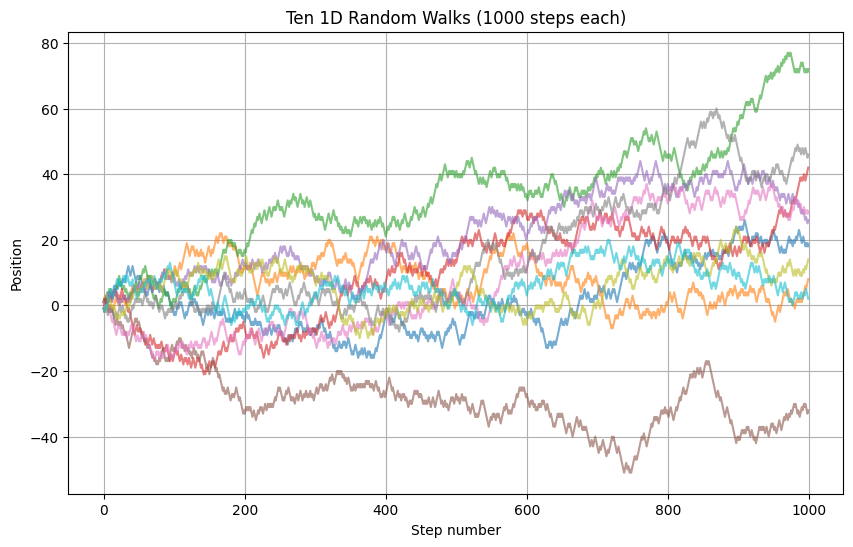

In [59]:
def random_walk_1d(n_steps):
    steps = np.random.choice([-1, 1], size=n_steps)
    position = np.cumsum(steps)
    return position

plt.figure(figsize=(10,6))
n_steps = 1000

for _ in range(10):
    pos = random_walk_1d(1000)
    plt.plot(pos, alpha=0.6)
plt.title("Ten 1D Random Walks (1000 steps each)")
plt.xlabel("Step number")
plt.ylabel("Position")
plt.grid(True)
plt.show()

**Question 1**: Describe the main features of the random walk trajectories. What do you notice about the spread of the paths as the number of steps increases?

---

Now, let's look at the distribution of final positions for 10,000 different random walks.

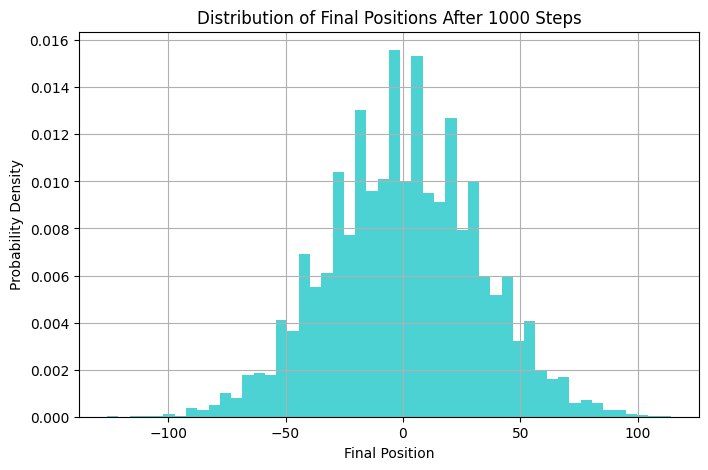

In [60]:
n_walks = 10000
final_positions = np.array([random_walk_1d(n_steps)[-1] for _ in range(n_walks)])

plt.figure(figsize=(8,5))
plt.hist(final_positions, bins=50, density=True, alpha=0.7, color='c')
plt.title("Distribution of Final Positions After 1000 Steps")
plt.xlabel("Final Position")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()

**Question 2**: What is the shape of the distribution of final positions? How does this relate to the Central Limit Theorem?

---

Plot the mean squared displacement (MSD), defined as:

$MSD(n)=⟨(x_n−x_0)^2⟩$

as a function of the number of steps n. Here, $x_0=0$ is the starting position.

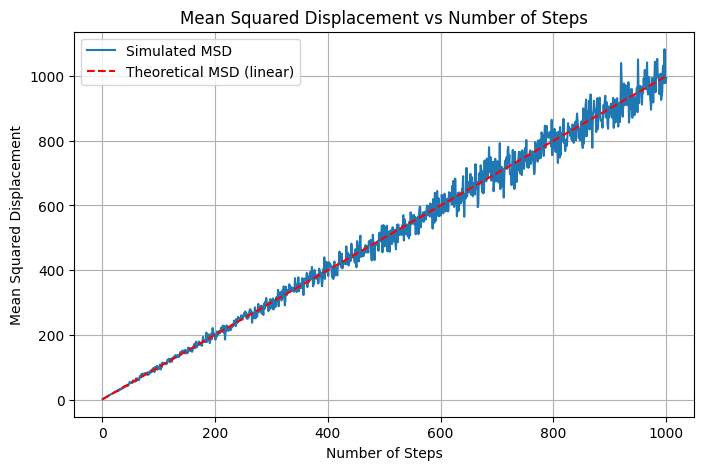

In [61]:
max_steps = 1000
msd = np.zeros(max_steps)
for step in range(1, max_steps+1):
    positions = np.array([random_walk_1d(step)[-1] for _ in range(1000)])
    msd[step-1] = np.mean(positions**2)

plt.figure(figsize=(8,5))
plt.plot(range(1, max_steps+1), msd, label="Simulated MSD")
plt.plot(range(1, max_steps+1), range(1, max_steps+1), 'r--', label="Theoretical MSD (linear)")
plt.title("Mean Squared Displacement vs Number of Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Mean Squared Displacement")
plt.legend()
plt.grid(True)
plt.show()

**Question 3**: How does the MSD grow as the number of steps increases? Is this consistent with theoretical expectations for a random walk?

# Part 2: The Metropolis Algorithm and Grain Boundary Stability

This section introduces the Metropolis Monte Carlo algorithm and its application to modeling grain boundary stability in metal alloys. You will use provided Python code to simulate a simplified 2D lattice model, analyze how grain boundaries evolve, and interpret the results in the context of thermodynamics and materials science.

Grain boundaries are interfaces between different crystalline orientations in polycrystalline metals. Their stability affects material properties such as mechanical response. In this section, we use a lattice model (similar to the Ising model) to represent grains: each site on a 2D grid has a "grain orientation" (an integer label). The "energy" of the system increases when neighboring sites have different orientations, analogous to the energy cost of grain boundaries.

The Metropolis algorithm is a Monte Carlo method for simulating the equilibrium properties of such systems. It works by proposing random changes to the system and accepting or rejecting them based on the change in energy and the system temperature, allowing the model to explore states according to the Boltzmann distribution. A basic outline is as follows:



*   Randomly select a site.
*   Propose changing its orientation.
*   Calculate the change in system energy ($ΔE$).
*   Accept or reject the change based on the Metropolis criterion:
  
   $P(accept)=
   \begin{cases}
    1 \text{,} \ \text{if} \ ΔE≤0 \\
    \text{exp}⁡(−ΔE/kT) \text{,} \ \text{if} \ ΔE>0
   \end{cases}
   $
*   Repeat for many steps to observe evolution toward equilibrium.


---

Let's start by generating a random seed tied to your UVA computing ID. Change seed_string below to be your UVA computing ID. Note that randomizer seeds will advance after being used, so if you want to re-run any of the code, restart from the section where your randomizer seed is generated.

In [83]:
def string_to_seed(s, default_value="UVA"):
    """Convert a string to a reproducible integer seed."""
    if s == default_value:
        raise ValueError(
            f"Error: seed string is set to the default value '{default_value}'. "
            "Please change it to your unique identifier (e.g., your computing ID)."
        )
    return abs(hash(s)) % (2**32)

seed_string = "UVA"  # Replace with your computing ID
seed = string_to_seed(seed_string)
rng = np.random.default_rng(seed)

---

Generate your initial lattice below. Note the initial lattice size (L = 50) and the number of unique grain orientations (n = 5).

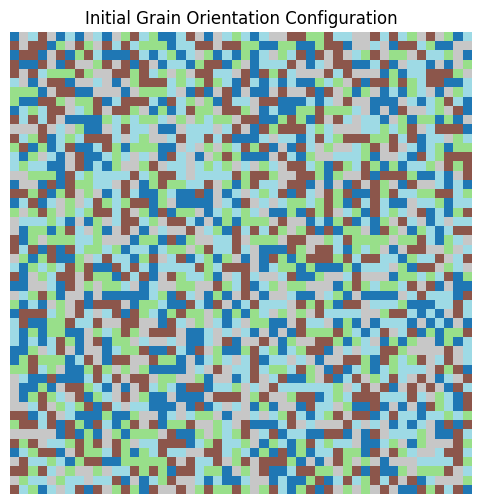

In [84]:
# Parameters
L = 50  # Lattice size (LxL)
n_orient = 5  # Number of grain orientations
k_B = 1.380649e-23  # Boltzmann constant in J/K

# Initialize lattice with random orientations
lattice = rng.integers(0, n_orient, size=(L, L))

def plot_lattice(lattice, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(lattice, cmap='tab20', interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_lattice(lattice, title="Initial Grain Orientation Configuration")


---

Run the code below to perform the Monte Carlo simulation using the Metropolis algorithm and visualize the evolution. This code will likely take over a minute to finish.

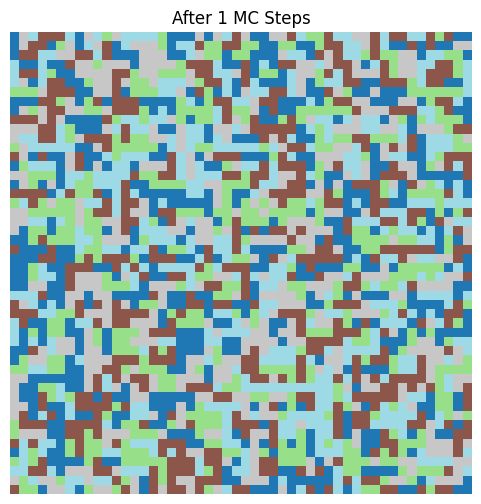

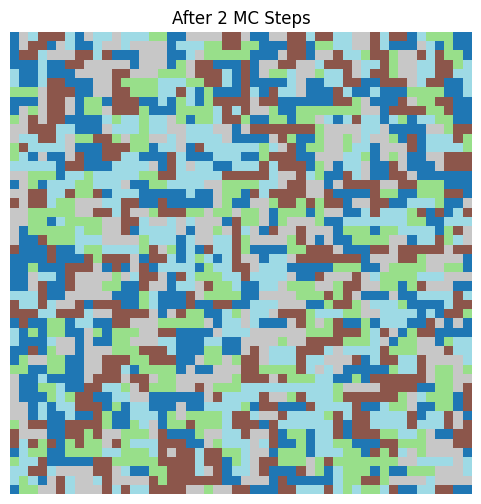

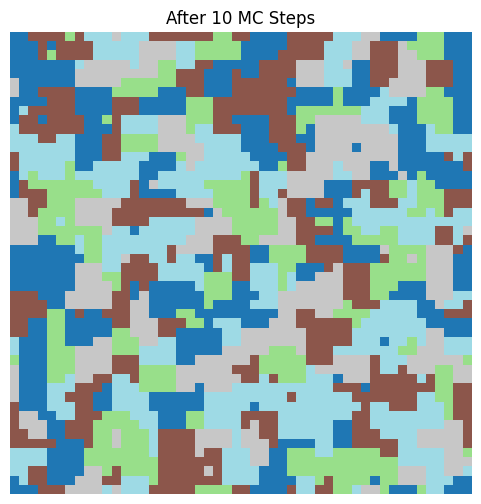

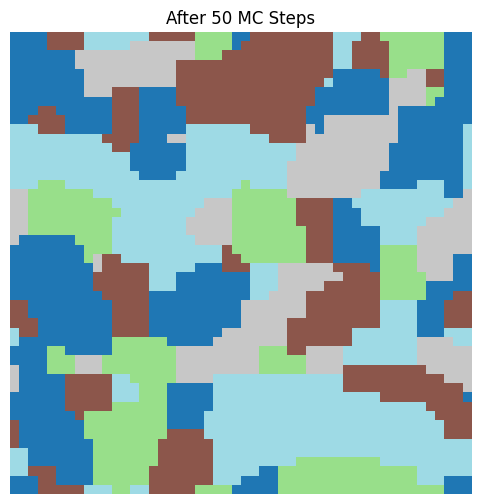

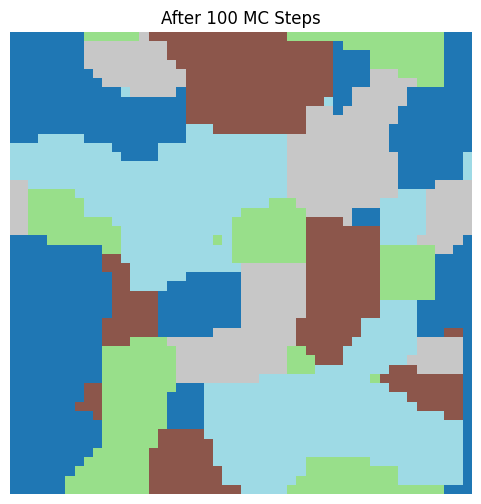

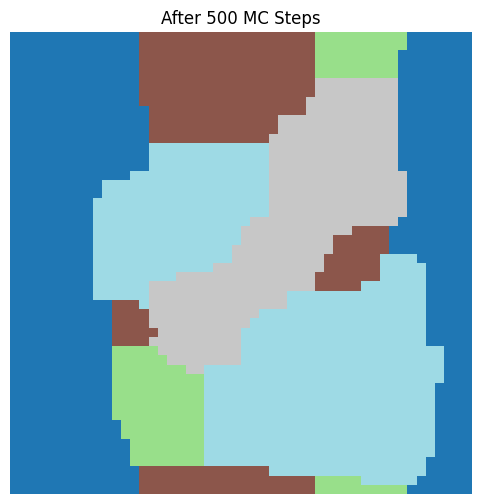

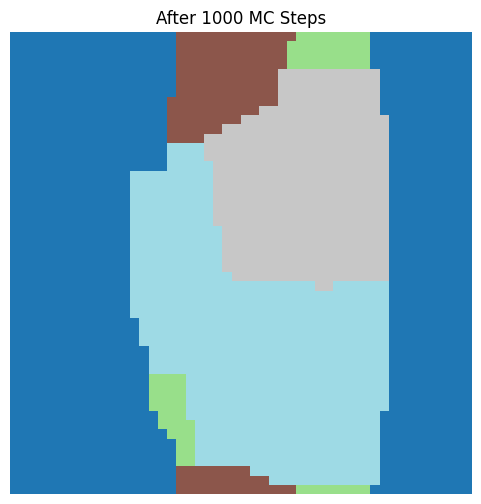

In [85]:
def energy_site(lattice, i, j):
    # Periodic boundary conditions
    L = lattice.shape[0]
    s = lattice[i, j]
    neighbors = [
        lattice[(i+1)%L, j],
        lattice[(i-1)%L, j],
        lattice[i, (j+1)%L],
        lattice[i, (j-1)%L]
    ]
    # Energy: +1 for each unlike neighbor
    return sum([1 for n in neighbors if n != s])

def metropolis_step(lattice, T, rng):
    L = lattice.shape[0]
    for _ in range(L*L):
        i, j = rng.integers(0, L, size=2)
        current = lattice[i, j]
        proposal = rng.choice([x for x in range(n_orient) if x != current])
        dE = 0
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = (i+di)%L, (j+dj)%L
            if lattice[ni, nj] != current:
                dE -= 1
            if lattice[ni, nj] != proposal:
                dE += 1
        dE_joules = dE * E_0
        if dE <= 0 or rng.random() < np.exp(-dE_joules / (k_B * T)):
            lattice[i, j] = proposal
    return lattice

def grain_boundary_fraction(lattice):
    L = lattice.shape[0]
    gb_sites = 0
    for i in range(L):
        for j in range(L):
            s = lattice[i, j]
            for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                ni, nj = (i+di)%L, (j+dj)%L
                if lattice[ni, nj] != s:
                    gb_sites += 1
    # Each boundary counted twice (once from each side)
    return gb_sites / (4*L*L)

# Simulation parameters
T = 300.0  # "Temperature in Kelvin"
n_steps = 1000
E_0 = 5e-20  # Joules per site (This is included because I want to use actual values for T.
             # If this weren't included, the boltzman constant dominates and temperature changes are meaningless.)

# Run simulation and visualize
lattice_sim = lattice.copy()
gb_fractions = []

for step in range(n_steps):
    lattice_sim = metropolis_step(lattice_sim, T, rng)
    gb_fractions.append(grain_boundary_fraction(lattice_sim))
    if step in [0, 1, 9, 49, 99, 499, 999]:
        plot_lattice(lattice_sim, title=f"After {step+1} MC Steps")

**Question 4**: How does the grain structure change as the simulation progresses? What is happening to the grain boundaries?


---

Now, let's plot the fraction of sites that are on a grain boundary as a function of Monte Carlo steps.

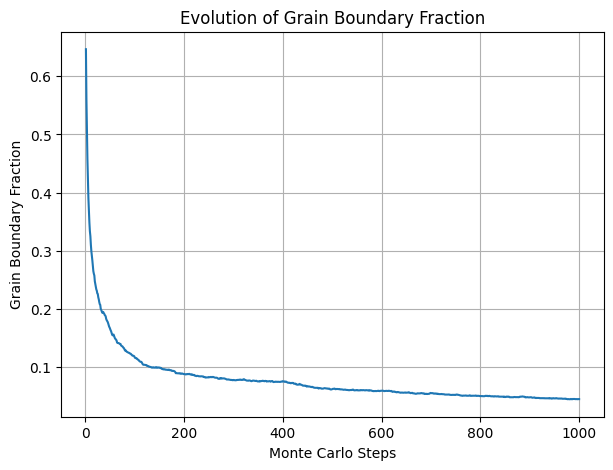

In [86]:
# Plot grain boundary fraction
plt.figure(figsize=(7,5))
plt.plot(range(1, n_steps+1), gb_fractions)
plt.xlabel("Monte Carlo Steps")
plt.ylabel("Grain Boundary Fraction")
plt.title("Evolution of Grain Boundary Fraction")
plt.grid(True)
plt.show()

**Question 5**: How does the grain boundary fraction change over time? What does this indicate about the system's evolution? Can we interpret anything physically meaningful from the intermediate Monte Carlo steps (i.e., at 200, 400, 600, etc. steps)?

---

What happens when we change temperature? Go back into the code above (save your images and figures before you do), re-run the simulation at two additional temperatures, **100** and **1000 K**, and observe how the grain structure and grain boundary fraction evolve.

**Question 6**: How does temperature affect the final grain structure and the grain boundary fraction? Relate this to the concept of thermal fluctuations and energy minimization.